# Big Shadow State Tomography

In [1]:
import numpy as np

from time import time
from tqdm import tqdm

import qiskit

from qiskit_aer import AerSimulator
from qiskit.visualization import plot_gate_map 

from qiskit_ibm_runtime.fake_provider import FakeLimaV2
from qiskit_ibm_runtime.fake_provider import FakeMontrealV2
from qiskit_ibm_runtime.fake_provider import FakeKyiv

from qiskit.circuit.random import random_circuit

import matplotlib.pyplot as plt

plt.style.use("dark_background")

%cd -q ../..

from rivet_transpiler import transpile_right

### Functions

In [2]:
def build_bases_rotation_circuit(bases):

    qubits_count = len(bases)

    circuit = qiskit.QuantumCircuit(qubits_count)

    for qubit, basis in enumerate(bases):

        if basis == "X":
            circuit.h(qubit)

        elif basis == "Y":
            circuit.sdg(qubit)
            circuit.h(qubit)

        elif basis == "Z":
            pass

    return circuit

### Backend

In [3]:
FAKE_BACKEND = FakeKyiv()

backend = AerSimulator.from_backend(FAKE_BACKEND)

# backend.options.noise_model = None

# qiskit.visualization.plot_gate_map(FAKE_BACKEND)

### Circuit

In [5]:
# Parameters

QUBITS_COUNT = 127
CIRCUIT_DEPTH = 1
MAX_GATE_SIZE = 4

BASES_COUNT = 1

OPTIMIZATION_LEVEL = 3

SEED = 1234

rng = np.random.default_rng(SEED) 

qubits = list(range(QUBITS_COUNT))

## Random Circuit

circuit = random_circuit(
    num_qubits=QUBITS_COUNT, 
    depth=CIRCUIT_DEPTH,
    max_operands=MAX_GATE_SIZE, 
    seed=SEED,
    measure=False)

circuit.draw(fold=-1)
# circuit.draw(fold=-1, output="mpl")

┌───┐                                                                                                                                                                                                                                                                                                                                          
  q_0: ─────────────────────────┤ Z ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                └───┘                                                                                                                                                                                                                                                                                                                                          
  q_1: ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■────────────────────────────────────────────────────────────────────────
                                                                                                                                                                                                                                ┌──────┐                                                              │                                                                        
  q_2: ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ √Xdg ├──────────────────────────────────────────────────────────────┼────────────────────────────────────────────────────────────────────────
                                                                                                                                                                                                                                └──────┘                                                              │                                                                        
  q_3: ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼────────────────■───────────────────────────────────────────────────────
                                                                                                                                                 ┌────────────┐                                                                                                                                       │                │                                                       
  q_4: ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ Ry(1.2647) ├───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼────────────────┼───────────────────────────────────────────────────────
                                                                            ┌───┐                                                                └─────┬──────┘                                                                                                                                       │                │                                        

### Measurement Bases

In [5]:
random_bases = rng.choice(['X','Y','Z'], size=(BASES_COUNT, QUBITS_COUNT))

bases_list, shots_counts = np.unique(random_bases, axis=0, return_counts=True)

bases_list.shape

(1, 127)

In [6]:
rotation_circuits = []

for bases in bases_list:

    rotation_circuit = build_bases_rotation_circuit(bases)

    rotation_circuits.append(rotation_circuit)

len(rotation_circuits)

1

### Basic Transpilation - Slower Version!


In [7]:
start_time = time()

# Compose and Transpile all Rotation Circuits

shadow_circuits = []

rotation_tracker = tqdm(rotation_circuits, unit=' basis', ncols=110)

for rotation_circuit in rotation_tracker:

    measurement_circuit = rotation_circuit.measure_all(inplace=False)

    measured_circuit = circuit.compose(measurement_circuit)

    # display(measured_circuit.draw(fold=-1))

    shadow_circuit = qiskit.transpile(
        measured_circuit,
        backend,
        seed_transpiler=SEED,
        optimization_level=OPTIMIZATION_LEVEL)

    shadow_circuits.append(shadow_circuit)

estimated_time = time() - start_time

print(f"estimated_time: {estimated_time:.02f}")

100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:20<00:00, 20.11s/ basis]

estimated_time: 20.12


### Transpile Right - Much Faster!

In [8]:
start_time = time()

# Transpile Central Part

transpiled_central_circuit = qiskit.transpile(
    circuit,
    backend,
    seed_transpiler=SEED,
    optimization_level=OPTIMIZATION_LEVEL)


# Transpile Right all Rotation Circuits

shadow_circuits = []

rotation_tracker = tqdm(rotation_circuits, unit=' basis', ncols=110)

for rotation_circuit in rotation_tracker:

    measurement_circuit = rotation_circuit.measure_all(inplace=False)

    shadow_circuit = transpile_right(
        transpiled_central_circuit,
        measurement_circuit,
        backend=backend,
        seed_transpiler=SEED,
        optimization_level=OPTIMIZATION_LEVEL)

    shadow_circuits.append(shadow_circuit)


estimated_time = time() - start_time

print(f"estimated_time: {estimated_time:.02f}")

100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.17 basis/s]

estimated_time: 19.56


### Compare Transpilation Times

In [52]:
bases_counts = list(range(1, 1000))

basic_transpile_time = 20
transpile_central_time = 18
transpile_right_time = 0.2

In [53]:
basic_transpile_totals = []
transpile_right_totals = []

for bases_count in bases_counts:

    basic_transpile_total = bases_count * basic_transpile_time

    transpile_right_total = transpile_central_time + bases_count * transpile_right_time
    
    basic_transpile_totals.append(basic_transpile_total)
    transpile_right_totals.append(transpile_right_total)

### Plots

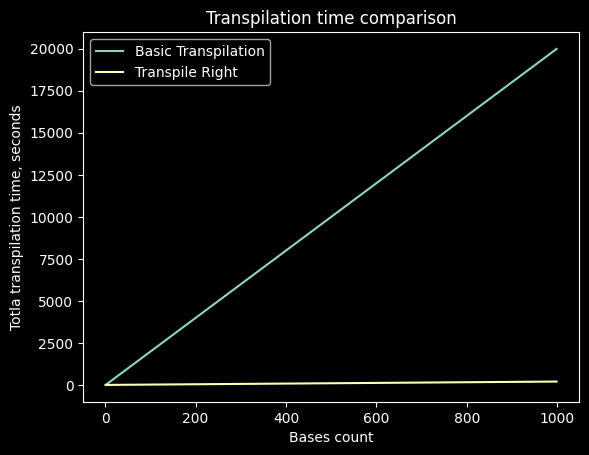

In [54]:
# Plot Transpilation times

plt.title("Transpilation time comparison")
plt.xlabel("Bases count")
plt.ylabel("Totla transpilation time, seconds")

plt.plot(bases_counts, basic_transpile_totals, label="Basic Transpilation")
plt.plot(bases_counts, transpile_right_totals, label="Transpile Right")

plt.legend()
plt.show()